In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
#from google.colab.patches import cv2_imshow
from IPython.display import display, HTML
import cv2 as cv2
import os
import matplotlib.pyplot as plt

In [ ]:
directorio_imagenes = '/content/drive/MyDrive/vision_computadora_I/Material_TPs/TP3/images'
ruta_template = '/content/drive/MyDrive/vision_computadora_I/Material_TPs/TP3/template/pattern.png'

# Cargar el template
template = cv2.imread(ruta_template, 0)
if template is not None:
    height_t, width_t = template.shape[:2]

# Inicializar las dimensiones mínimas con valores muy grandes
min_width = float('inf')
min_height = float('inf')

# Iterar sobre todos los archivos en el directorio
for archivo in os.listdir(directorio_imagenes):
    if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        ruta_imagen = os.path.join(directorio_imagenes, archivo)
        imagen = cv2.imread(ruta_imagen)

        if imagen is not None:
            height, width = imagen.shape[:2]
            print(f"Imagen: {archivo} - Ancho: {width} píxeles, Altura: {height} píxeles")


# Comparar con las dimensiones del template después de iterar sobre todas las imágenes
if template is not None:
    min_width = min(min_width, width_t)
    min_height = min(min_height, height_t)

# Imprimir las dimensiones del template para segmentar las que son mas pequeñas que el template
print()
print(f"Template: - Ancho: {width_t} píxeles, Altura: {height_t} píxeles")

Imagen: COCA-COLA-LOGO.jpg - Ancho: 1389 píxeles, Altura: 1389 píxeles
Imagen: coca_logo_1.png - Ancho: 207 píxeles, Altura: 500 píxeles
Imagen: coca_logo_2.png - Ancho: 233 píxeles, Altura: 363 píxeles
Imagen: coca_multi.png - Ancho: 799 píxeles, Altura: 598 píxeles
Imagen: coca_retro_1.png - Ancho: 715 píxeles, Altura: 493 píxeles
Imagen: coca_retro_2.png - Ancho: 715 píxeles, Altura: 429 píxeles
Imagen: logo_1.png - Ancho: 687 píxeles, Altura: 450 píxeles

Template: - Ancho: 400 píxeles, Altura: 175 píxeles


In [ ]:
#Aplicamos Canny a Template
if template is not None:
    # Aplicar Canny con umbrales 50 y 200
    template_ = cv2.imread(ruta_template, cv2.IMREAD_GRAYSCALE)
    bordes_template = cv2.Canny(template_, 50, 200)
    height_tc, width_tc = template.shape[:2]
    print(f"Template_Canny: - Ancho: {width_tc} píxeles, Altura: {height_tc} píxeles")
else:
    print("Error al cargar la imagen del template.")

bordes_template

Template_Canny: - Ancho: 400 píxeles, Altura: 175 píxeles


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Procesando: COCA-COLA-LOGO.jpg


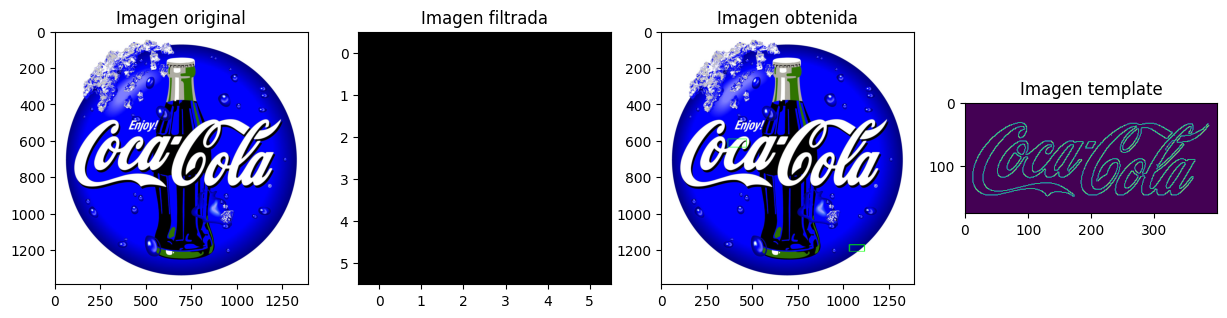

Procesando: coca_logo_1.png


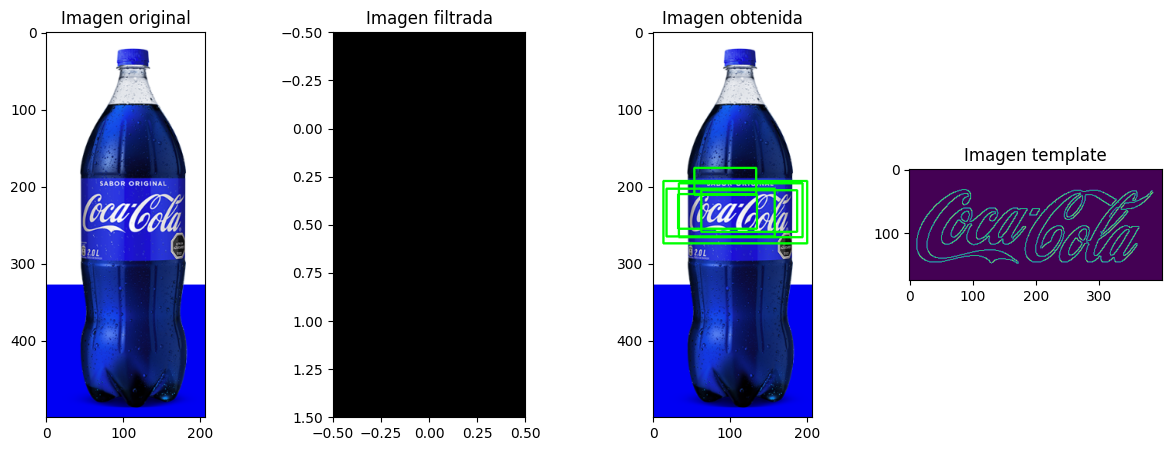

Procesando: coca_logo_2.png


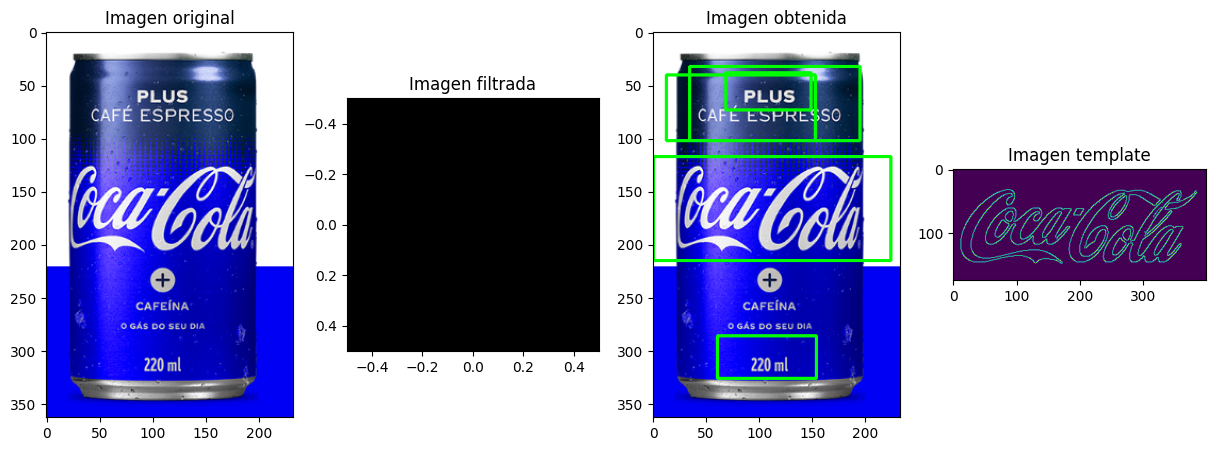

Procesando: coca_multi.png


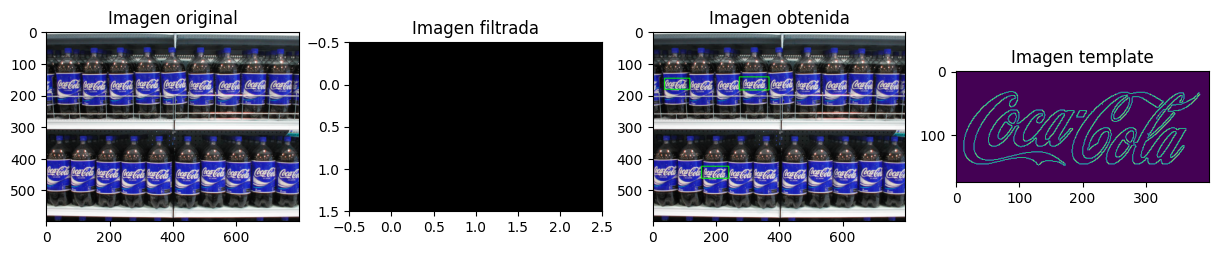

Procesando: coca_retro_1.png


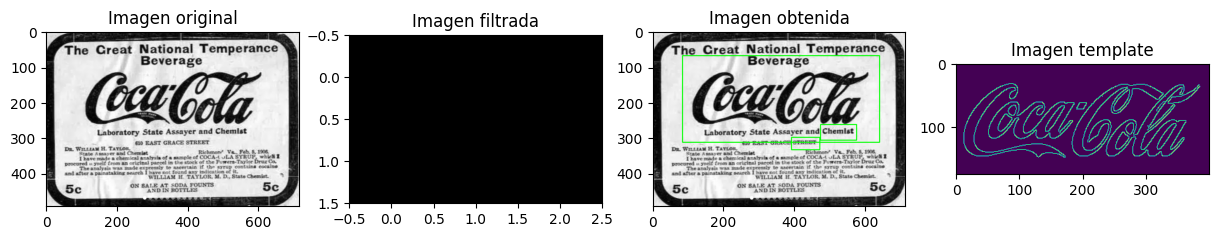

Procesando: coca_retro_2.png


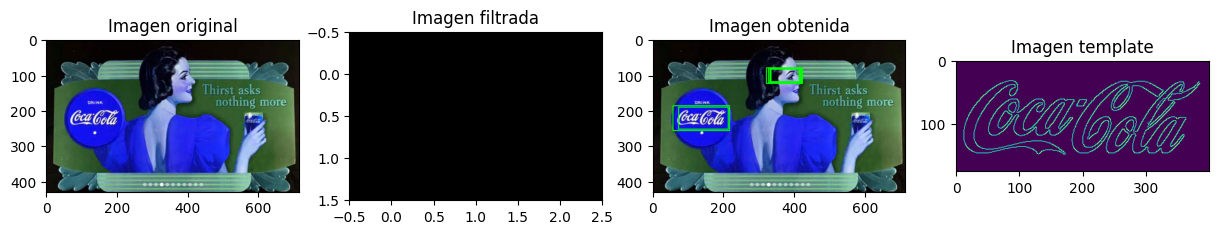

Procesando: logo_1.png


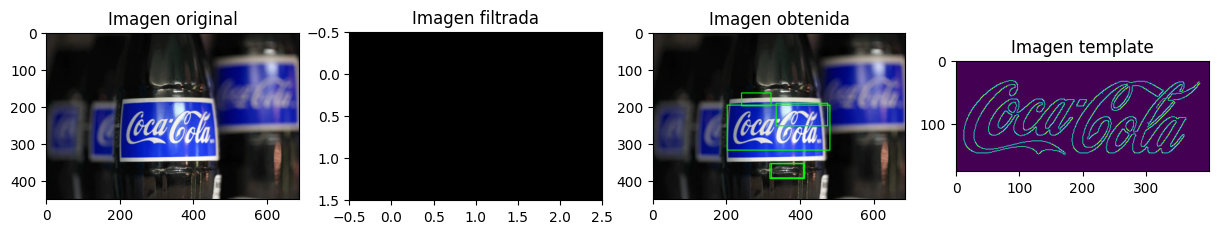

In [ ]:
# Lista para almacenar las imágenes procesadas (Si no hago esto se imprimira la misma imagen 6 veces)
imagenes_procesadas = []

# Iterar sobre todos los archivos en el directorio
for archivo in os.listdir(directorio_imagenes):
    if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        ruta_imagen = os.path.join(directorio_imagenes, archivo)
        img = cv2.imread(ruta_imagen)

        if img is not None:
            output = img.copy()

            # Inicialización de variables
            coordenada = None
            map = None
            resultado = None
            mejor_match = None
            mejor_escala = None

            for scale in np.linspace(0.005, 5.0, 15)[::-1]:
                # Convertir la imagen a RGB para visualización y copia
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Convertir la imagen a escala de grises
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Escalar la imagen
                altura, anchura = img_gray.shape
                img_escalada = cv2.resize(img_gray, (int(img_gray.shape[1] * scale), int(img_gray.shape[0] * scale)), interpolation=cv2.INTER_AREA)


                # Aplicar un desenfoque gaussiano
                img_desenfocada = cv2.GaussianBlur(img_escalada, (5, 5), 12)

                # Aplicar un umbral adaptativo
                img_umbral = cv2.adaptiveThreshold(img_desenfocada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 25)

                # Aplicar detección de bordes Canny
                img_canny = cv2.Canny(img_umbral, 100, 200)

                if img_escalada.shape[0] <= template.shape[0] or img_escalada.shape[1] <= template.shape[1]:
                    continue


                res = cv2.matchTemplate(img_canny, bordes_template, cv2.TM_CCOEFF)

                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                if mejor_match is None or max_val > mejor_match:
                    mejor_match = max_val
                    mejor_escala = scale
                    coordenada = max_loc
                    map = res
                    resultado = img_escalada.copy()
                if coordenada is not None:
                    top_left = (int(coordenada[0] / mejor_escala), int(coordenada[1] / mejor_escala))
                    bottom_right = (int((coordenada[0] + bordes_template.shape[1]) / mejor_escala), int((coordenada[1] + bordes_template.shape[0]) / mejor_escala))
                    cv2.rectangle(output, top_left, bottom_right, (0, 255, 0), 2)



            # Graficar los resultados
            print(f"Procesando: {archivo}")
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(img)
            plt.title("Imagen original")

            plt.subplot(1, 4, 2)
            plt.imshow(img_canny, cmap='gray')
            plt.title("Imagen filtrada")

            plt.subplot(1, 4, 3)
            plt.imshow(output)
            plt.title("Imagen obtenida")

            plt.subplot(1, 4, 4)
            plt.imshow(bordes_template)
            plt.title("Imagen template")

            plt.show()


